In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tifffile as tf
import os
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [2]:
def nanRobustBlur(I, dim):
    V=I.copy()
    V[I!=I]=0
    VV=cv2.blur(V,dim)   
    W=0*I.copy()+1
    W[I!=I]=0
    WW=cv2.blur(W,dim)    
    Z=VV/WW
    return Z 

In [3]:
anisotropy = cv2.imread('img_retardance3D_t000_p000_z044.tif', -1).astype('float32')
orientation = cv2.imread('img_azimuth_t000_p000_z044.tif', -1).astype('float32')

In [4]:
ps = 6.9/63
wavelength = 0.532

orientation = orientation / 18000*np.pi
anisotropy = anisotropy / 10000

In [5]:
def return_smooth(orientation, anisotropy):
    U, V =  anisotropy*np.cos(2 * orientation), anisotropy*np.sin(2 * orientation)
    USmooth = nanRobustBlur(U, (5, 5)) # plot smoothed vector field
    VSmooth = nanRobustBlur(V, (5, 5)) # plot smoothed vector field
    azimuthSmooth = (0.5*np.arctan2(VSmooth,USmooth)) % np.pi
    RSmooth = np.sqrt(USmooth**2+VSmooth**2)
    
    return RSmooth, azimuthSmooth

In [6]:
anisotropy, orientation = return_smooth(orientation, anisotropy)

In [7]:
def return_D(position):
    scale_value = anisotropy[position[0]][position[1]]
    theta = orientation[position[0]][position[1]]
    
    scale_matrix = np.matrix([[scale_value, 0], [0, 1]])
    angle_matrix = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    angle_matrix_2 = np.matrix([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    
    D_matrix = angle_matrix*scale_matrix*angle_matrix_2
    
    return D_matrix

In [8]:
D1 = np.zeros_like(anisotropy, dtype=np.float32)
D2 = np.zeros_like(anisotropy, dtype=np.float32)
D3 = np.zeros_like(anisotropy, dtype=np.float32)
D4 = np.zeros_like(anisotropy, dtype=np.float32)

x = np.arange(0, anisotropy.shape[0], 1)
y = np.arange(0, anisotropy.shape[1], 1)

for i in x:
    for j in y:
        scale_matrix = return_D([i, j])

        D1[i, j] = scale_matrix[0, 0]
        D2[i, j] = scale_matrix[0, 1]
        D3[i, j] = scale_matrix[1, 0]
        D4[i, j] = scale_matrix[1, 1]

In [9]:
from scipy import interpolate

In [10]:
D1_interp = interpolate.interp2d(x, y, D1, kind='cubic')
D2_interp = interpolate.interp2d(x, y, D2, kind='cubic')
D3_interp = interpolate.interp2d(x, y, D3, kind='cubic')
D4_interp = interpolate.interp2d(x, y, D4, kind='cubic')

In [11]:
def return_D_interp(position):
    D1_value = D1_interp(position[0], position[1])[0]
    D2_value = D2_interp(position[0], position[1])[0]
    D3_value = D3_interp(position[0], position[1])[0]
    D4_value = D4_interp(position[0], position[1])[0]
    
    return np.matrix([[D1_value, D2_value], [D3_value, D4_value]])

In [12]:
gamma = 0.5
def force_function(r):
    if 0 < r < 1:
        return r - 1
    elif 1 <= r <= 1 + gamma:
        return ((r-1)*(1+gamma-r)**2)/gamma**2
    elif r > 1 + gamma:
        return 0

In [13]:
def return_D_inverse(pos_a, pos_b):
    D_a = return_D_interp(pos_a)
    D_b = return_D_interp(pos_b)
    
    D_inverse_ab = (np.linalg.inv(D_a) + np.linalg.inv(D_b))/2
    
    return D_inverse_ab

In [14]:
alpha = 1000
def return_x_ab(pos_a, pos_b):
    D_inv_ab = return_D_inverse(pos_a, pos_b)
    
    pos_a = np.asarray(pos_a, dtype='float32')
    pos_b = np.asarray(pos_b, dtype='float32')
    y_ab = pos_a - pos_b
    y_ab = y_ab.reshape((2, 1))
    
    return D_inv_ab*y_ab/(2*alpha)

In [15]:
from numpy import linalg as LA
def return_force(pos_a, pos_b):
    x_ab = return_x_ab(pos_a, pos_b)
    x_ab_dist = LA.norm(x_ab)
    D_inv_ab = return_D_inverse(pos_a, pos_b)

    return (-force_function(x_ab_dist)*D_inv_ab*x_ab)/(2*alpha*x_ab_dist)

In [16]:
initial_num_points = 200
final_points = 100
random_rows = np.random.choice(anisotropy.shape[0], initial_num_points)
random_columns = np.random.choice(anisotropy.shape[1], initial_num_points)
random_points = list(zip(random_rows, random_columns))

In [17]:
det_D_list = [np.linalg.det(return_D_interp(pos)) for pos in random_points]
points_rejected = np.random.choice(len(random_points), initial_num_points - final_points, det_D_list)
final_points = [random_points[i] for i in range(len(random_points)) if i not in points_rejected]

In [18]:
def total_force_on_point(index):
    total_force = np.zeros((2, 1))
    p_a = final_points[index]
    for point in final_points:
        if point != p_a:
            f = return_force(p_a, point)
            total_force += f
    
    return total_force

In [19]:
def diff_equation(y, t, c_drag, total_force):
    p0, p1, r0, r1 = y
    dydt = [r0, r1, total_force[0] - 1*r0, total_force[1] - 1*r1]
    return dydt

In [20]:
from scipy.integrate import odeint
def solve_particle_path(index):
    c_drag = 1.0
    y0 = [final_points[index][0], final_points[index][1], 0.0, 0.0]
    t = np.linspace(0, 100, 1001)
    
    tf = total_force_on_point(index)
    
    sol = odeint(diff_equation, y0, t, args=(c_drag, tf))
    
    return sol

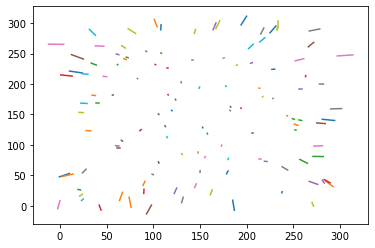

In [21]:
for i in range(len(final_points)):
    sol = solve_particle_path(i)
    plt.plot(sol[:,0], sol[:,1])
plt.show()